# Stroke Prediction Analysis (India)

**Ishak Islam** | UMID28072552431 | Unified Mentor Internship

---

This notebook analyzes stroke risk factors using healthcare data. The analysis examines patient demographics, medical history, and lifestyle factors to identify patterns associated with stroke occurrence.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set style (handle different matplotlib versions)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        pass
sns.set_palette('husl')

# Define paths
DATA_DIR = Path('../data')
VIZ_DIR = Path('../visualizations')
TABLEAU_DIR = Path('../tableau')

VIZ_DIR.mkdir(exist_ok=True)
TABLEAU_DIR.mkdir(exist_ok=True)

# Color palette
COLORS = {
    'no_stroke': '#2ecc71',
    'stroke': '#e74c3c',
    'primary': '#3498db',
    'warning': '#f39c12',
    'neutral': '#95a5a6'
}

print('Setup complete!')

Setup complete!


## 2. Load Data

**Dataset Source:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Download the dataset and place `healthcare-dataset-stroke-data.csv` in the `data/` folder.

In [2]:
# Load stroke data
try:
    df = pd.read_csv(DATA_DIR / 'healthcare-dataset-stroke-data.csv')
    print(f'Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns')
except FileNotFoundError:
    print('File not found: healthcare-dataset-stroke-data.csv')
    print('Please download from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset')
    df = None

Dataset loaded: 5,110 rows, 12 columns


## 3. Data Exploration

In [3]:
# Preview the data
print('First 10 rows:')
df.head(10)

First 10 rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [4]:
# Data info
print('Dataset Info:')
print(f'Shape: {df.shape}')
print(f'\nColumn Types:')
print(df.dtypes)

Dataset Info:
Shape: (5110, 12)

Column Types:
id                     int64
gender                   str
age                  float64
hypertension           int64
heart_disease          int64
ever_married             str
work_type                str
Residence_type           str
avg_glucose_level    float64
bmi                  float64
smoking_status           str
stroke                 int64
dtype: object


In [5]:
# Check for missing values
print('Missing Values:')
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else 'No null values found')

# Check for 'N/A' string in BMI
if df['bmi'].dtype == 'object':
    na_count = (df['bmi'] == 'N/A').sum()
    print(f"\nBMI 'N/A' values: {na_count}")

Missing Values:
bmi    201
dtype: int64


In [6]:
# Basic statistics for numeric columns
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
# Check unique values in categorical columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    print(f'\n{col}:')
    print(df[col].value_counts())


gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


## 4. Data Cleaning

In [8]:
# Create a copy for cleaning
df_clean = df.copy()

# Handle BMI missing values (marked as 'N/A')
df_clean['bmi'] = pd.to_numeric(df_clean['bmi'], errors='coerce')
bmi_median = df_clean['bmi'].median()
df_clean['bmi'] = df_clean['bmi'].fillna(bmi_median)
print(f'BMI missing values filled with median: {bmi_median:.2f}')

# Remove 'Other' gender (only 1 record)
other_count = (df_clean['gender'] == 'Other').sum()
df_clean = df_clean[df_clean['gender'] != 'Other']
print(f'Removed {other_count} record(s) with gender="Other"')

print(f'\nCleaned dataset: {df_clean.shape[0]:,} rows')

BMI missing values filled with median: 28.10
Removed 1 record(s) with gender="Other"

Cleaned dataset: 5,109 rows


In [9]:
# Create derived columns

# Age groups
bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '75+']
df_clean['age_group'] = pd.cut(df_clean['age'], bins=bins, labels=labels, include_lowest=True)

# BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['bmi_category'] = df_clean['bmi'].apply(categorize_bmi)

# Glucose categories
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal'
    elif glucose < 126:
        return 'Pre-diabetic'
    else:
        return 'Diabetic'

df_clean['glucose_category'] = df_clean['avg_glucose_level'].apply(categorize_glucose)

print('Derived columns created: age_group, bmi_category, glucose_category')
df_clean.head()

Derived columns created: age_group, bmi_category, glucose_category


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,bmi_category,glucose_category
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,61-75,Obese,Diabetic
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,61-75,Overweight,Diabetic
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75+,Obese,Pre-diabetic
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,46-60,Obese,Diabetic
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,75+,Normal,Diabetic


## 5. Stroke Statistics

In [10]:
# Overall stroke statistics
total = len(df_clean)
stroke_cases = df_clean['stroke'].sum()
no_stroke = total - stroke_cases
stroke_rate = stroke_cases / total * 100

print('=' * 50)
print('STROKE STATISTICS')
print('=' * 50)
print(f'Total Patients: {total:,}')
print(f'Stroke Cases: {stroke_cases:,} ({stroke_rate:.2f}%)')
print(f'No Stroke: {no_stroke:,} ({100-stroke_rate:.2f}%)')
print('=' * 50)

STROKE STATISTICS
Total Patients: 5,109
Stroke Cases: 249 (4.87%)
No Stroke: 4,860 (95.13%)


In [11]:
# Helper function for stroke rate by category
def get_stroke_rate(data, column):
    """Calculate stroke statistics by category."""
    grouped = data.groupby(column).agg(
        total=('stroke', 'count'),
        stroke_cases=('stroke', 'sum')
    ).reset_index()
    grouped['stroke_rate'] = (grouped['stroke_cases'] / grouped['total'] * 100).round(2)
    return grouped

## 6. Analysis by Risk Factors

### 6.1 Age Analysis

In [12]:
# Age statistics
print('Age Statistics:')
print(f'  Mean Age: {df_clean["age"].mean():.1f}')
print(f'  Median Age: {df_clean["age"].median():.1f}')
print(f'  Min Age: {df_clean["age"].min():.1f}')
print(f'  Max Age: {df_clean["age"].max():.1f}')

print('\nAge by Stroke Status:')
print(df_clean.groupby('stroke')['age'].agg(['mean', 'median', 'std']).round(2))

Age Statistics:
  Mean Age: 43.2
  Median Age: 45.0
  Min Age: 0.1
  Max Age: 82.0

Age by Stroke Status:
         mean  median    std
stroke                      
0       41.97    43.0  22.29
1       67.73    71.0  12.73


In [13]:
# Stroke rate by age group
age_stats = get_stroke_rate(df_clean, 'age_group')
print('\nStroke Rate by Age Group:')
print(age_stats.to_string(index=False))


Stroke Rate by Age Group:
age_group  total  stroke_cases  stroke_rate
     0-18    916             2         0.22
    19-30    653             0         0.00
    31-45   1048            11         1.05
    46-60   1188            59         4.97
    61-75    839            81         9.65
      75+    465            96        20.65


### 6.2 Gender Analysis

In [14]:
# Stroke rate by gender
gender_stats = get_stroke_rate(df_clean, 'gender')
print('Stroke Rate by Gender:')
print(gender_stats.to_string(index=False))

Stroke Rate by Gender:
gender  total  stroke_cases  stroke_rate
Female   2994           141         4.71
  Male   2115           108         5.11


### 6.3 Medical Conditions Analysis

In [15]:
# Hypertension impact
hyper_stats = get_stroke_rate(df_clean, 'hypertension')
hyper_stats['hypertension'] = hyper_stats['hypertension'].map({0: 'No', 1: 'Yes'})
print('Stroke Rate by Hypertension Status:')
print(hyper_stats.to_string(index=False))

Stroke Rate by Hypertension Status:
hypertension  total  stroke_cases  stroke_rate
          No   4611           183         3.97
         Yes    498            66        13.25


In [16]:
# Heart disease impact
heart_stats = get_stroke_rate(df_clean, 'heart_disease')
heart_stats['heart_disease'] = heart_stats['heart_disease'].map({0: 'No', 1: 'Yes'})
print('Stroke Rate by Heart Disease Status:')
print(heart_stats.to_string(index=False))

Stroke Rate by Heart Disease Status:
heart_disease  total  stroke_cases  stroke_rate
           No   4833           202         4.18
          Yes    276            47        17.03


### 6.4 Lifestyle Factors Analysis

In [17]:
# Smoking status impact
smoking_stats = get_stroke_rate(df_clean, 'smoking_status')
smoking_stats = smoking_stats.sort_values('stroke_rate', ascending=False)
print('Stroke Rate by Smoking Status:')
print(smoking_stats.to_string(index=False))

Stroke Rate by Smoking Status:
 smoking_status  total  stroke_cases  stroke_rate
formerly smoked    884            70         7.92
         smokes    789            42         5.32
   never smoked   1892            90         4.76
        Unknown   1544            47         3.04


In [18]:
# BMI category impact
bmi_stats = get_stroke_rate(df_clean, 'bmi_category')
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
bmi_stats['bmi_category'] = pd.Categorical(bmi_stats['bmi_category'], categories=bmi_order, ordered=True)
bmi_stats = bmi_stats.sort_values('bmi_category')
print('Stroke Rate by BMI Category:')
print(bmi_stats.to_string(index=False))

Stroke Rate by BMI Category:
bmi_category  total  stroke_cases  stroke_rate
 Underweight    337             1         0.30
      Normal   1242            35         2.82
  Overweight   1610           115         7.14
       Obese   1920            98         5.10


In [19]:
# Glucose level impact
glucose_stats = get_stroke_rate(df_clean, 'glucose_category')
glucose_order = ['Normal', 'Pre-diabetic', 'Diabetic']
glucose_stats['glucose_category'] = pd.Categorical(glucose_stats['glucose_category'], categories=glucose_order, ordered=True)
glucose_stats = glucose_stats.sort_values('glucose_category')
print('Stroke Rate by Glucose Category:')
print(glucose_stats.to_string(index=False))

Stroke Rate by Glucose Category:
glucose_category  total  stroke_cases  stroke_rate
          Normal   3131           112         3.58
    Pre-diabetic    998            37         3.71
        Diabetic    980           100        10.20


### 6.5 Work and Residence Analysis

In [20]:
# Work type impact
work_stats = get_stroke_rate(df_clean, 'work_type')
work_stats = work_stats.sort_values('stroke_rate', ascending=False)
print('Stroke Rate by Work Type:')
print(work_stats.to_string(index=False))

Stroke Rate by Work Type:
    work_type  total  stroke_cases  stroke_rate
Self-employed    819            65         7.94
      Private   2924           149         5.10
     Govt_job    657            33         5.02
     children    687             2         0.29
 Never_worked     22             0         0.00


In [21]:
# Residence type impact
residence_stats = get_stroke_rate(df_clean, 'Residence_type')
print('Stroke Rate by Residence Type:')
print(residence_stats.to_string(index=False))

Stroke Rate by Residence Type:
Residence_type  total  stroke_cases  stroke_rate
         Rural   2513           114         4.54
         Urban   2596           135         5.20


## 7. Visualizations

In [22]:
# Helper function to save figures
def save_fig(fig, filename):
    """Save figure to visualizations folder."""
    filepath = VIZ_DIR / filename
    fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f'Saved: {filepath}')

Saved: ../visualizations/01_stroke_distribution.png


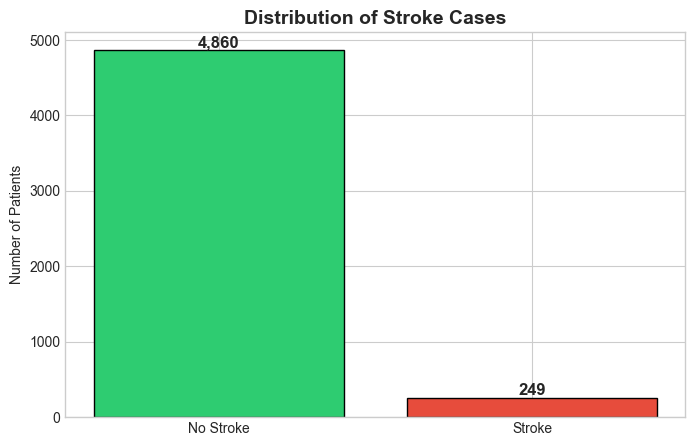

In [23]:
# 1. Stroke Distribution
fig, ax = plt.subplots(figsize=(8, 5))
stroke_counts = df_clean['stroke'].value_counts()
bars = ax.bar(['No Stroke', 'Stroke'], stroke_counts.values, 
              color=[COLORS['no_stroke'], COLORS['stroke']], edgecolor='black')
for bar, count in zip(bars, stroke_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Stroke Cases', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patients')
save_fig(fig, '01_stroke_distribution.png')
plt.show()

Saved: ../visualizations/02_age_distribution.png


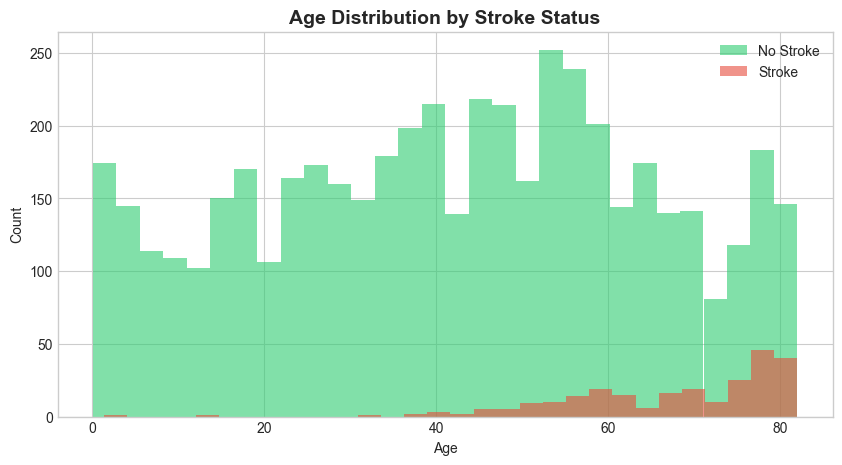

In [24]:
# 2. Age Distribution by Stroke Status
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_clean[df_clean['stroke']==0]['age'], bins=30, alpha=0.6, 
        label='No Stroke', color=COLORS['no_stroke'])
ax.hist(df_clean[df_clean['stroke']==1]['age'], bins=30, alpha=0.6, 
        label='Stroke', color=COLORS['stroke'])
ax.set_title('Age Distribution by Stroke Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()
save_fig(fig, '02_age_distribution.png')
plt.show()

Saved: ../visualizations/03_age_group_stroke_rate.png


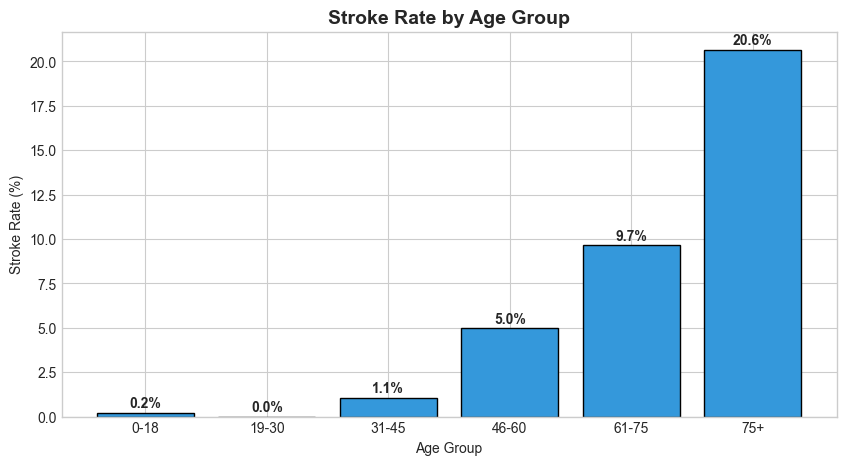

In [25]:
# 3. Stroke Rate by Age Group
fig, ax = plt.subplots(figsize=(10, 5))
age_data = get_stroke_rate(df_clean, 'age_group')
bars = ax.bar(age_data['age_group'].astype(str), age_data['stroke_rate'], 
              color=COLORS['primary'], edgecolor='black')
for bar, rate in zip(bars, age_data['stroke_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{rate:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax.set_title('Stroke Rate by Age Group', fontsize=14, fontweight='bold')
ax.set_xlabel('Age Group')
ax.set_ylabel('Stroke Rate (%)')
save_fig(fig, '03_age_group_stroke_rate.png')
plt.show()

Saved: ../visualizations/04_gender_analysis.png


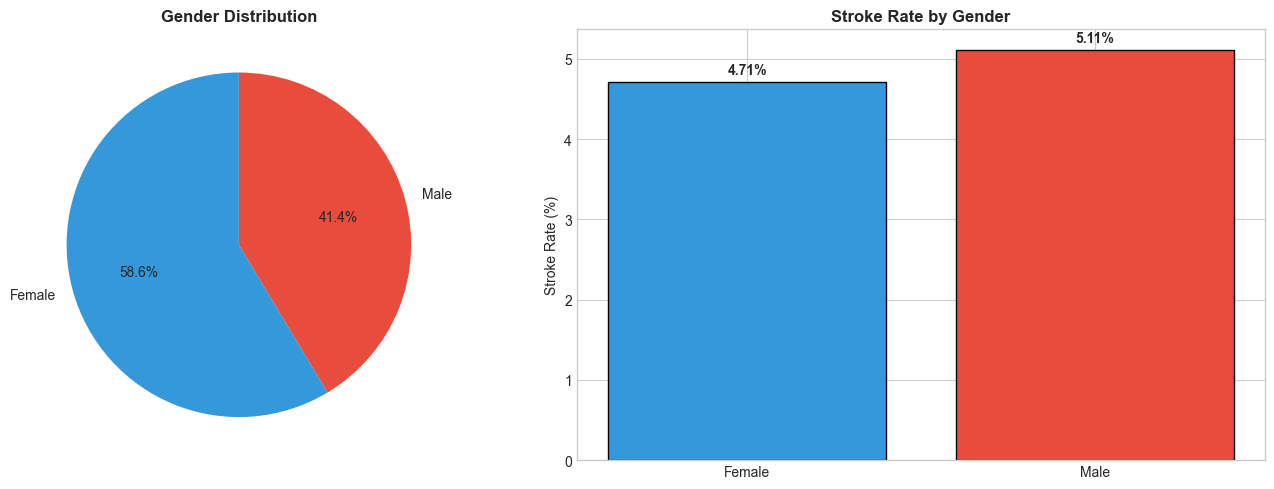

In [26]:
# 4. Gender Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender distribution
gender_counts = df_clean['gender'].value_counts()
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
            colors=[COLORS['primary'], COLORS['stroke']], startangle=90)
axes[0].set_title('Gender Distribution', fontsize=12, fontweight='bold')

# Stroke rate by gender
gender_data = get_stroke_rate(df_clean, 'gender')
bars = axes[1].bar(gender_data['gender'], gender_data['stroke_rate'],
                   color=[COLORS['primary'], COLORS['stroke']], edgecolor='black')
for bar, rate in zip(bars, gender_data['stroke_rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
axes[1].set_title('Stroke Rate by Gender', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Stroke Rate (%)')

plt.tight_layout()
save_fig(fig, '04_gender_analysis.png')
plt.show()

Saved: ../visualizations/05_medical_conditions.png


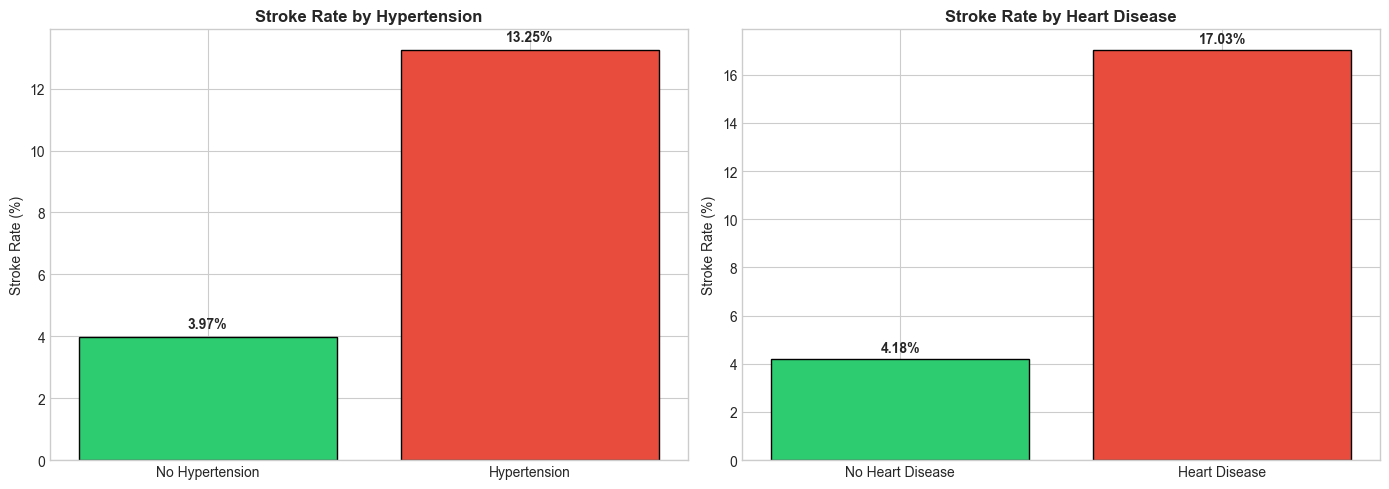

In [27]:
# 5. Medical Conditions Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hypertension
hyper_data = get_stroke_rate(df_clean, 'hypertension')
labels = ['No Hypertension', 'Hypertension']
bars1 = axes[0].bar(labels, hyper_data['stroke_rate'], 
                    color=[COLORS['no_stroke'], COLORS['stroke']], edgecolor='black')
for bar, rate in zip(bars1, hyper_data['stroke_rate']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
axes[0].set_title('Stroke Rate by Hypertension', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Stroke Rate (%)')

# Heart Disease
heart_data = get_stroke_rate(df_clean, 'heart_disease')
labels = ['No Heart Disease', 'Heart Disease']
bars2 = axes[1].bar(labels, heart_data['stroke_rate'], 
                    color=[COLORS['no_stroke'], COLORS['stroke']], edgecolor='black')
for bar, rate in zip(bars2, heart_data['stroke_rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
axes[1].set_title('Stroke Rate by Heart Disease', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Stroke Rate (%)')

plt.tight_layout()
save_fig(fig, '05_medical_conditions.png')
plt.show()

Saved: ../visualizations/06_smoking_analysis.png


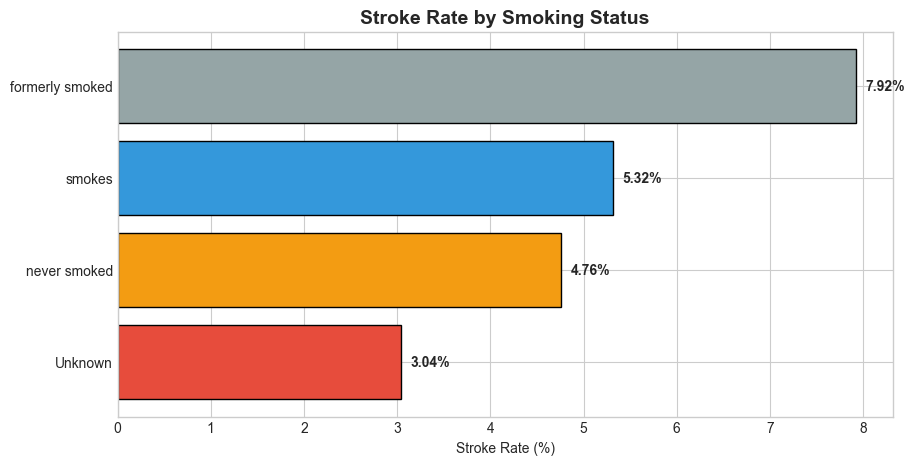

In [28]:
# 6. Smoking Analysis
fig, ax = plt.subplots(figsize=(10, 5))
smoking_data = get_stroke_rate(df_clean, 'smoking_status').sort_values('stroke_rate', ascending=True)
colors = [COLORS['stroke'], COLORS['warning'], COLORS['primary'], COLORS['neutral']]
bars = ax.barh(smoking_data['smoking_status'], smoking_data['stroke_rate'], 
               color=colors[:len(smoking_data)], edgecolor='black')
for bar, rate in zip(bars, smoking_data['stroke_rate']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{rate:.2f}%', ha='left', va='center', fontsize=10, fontweight='bold')
ax.set_title('Stroke Rate by Smoking Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Stroke Rate (%)')
save_fig(fig, '06_smoking_analysis.png')
plt.show()

Saved: ../visualizations/07_bmi_analysis.png


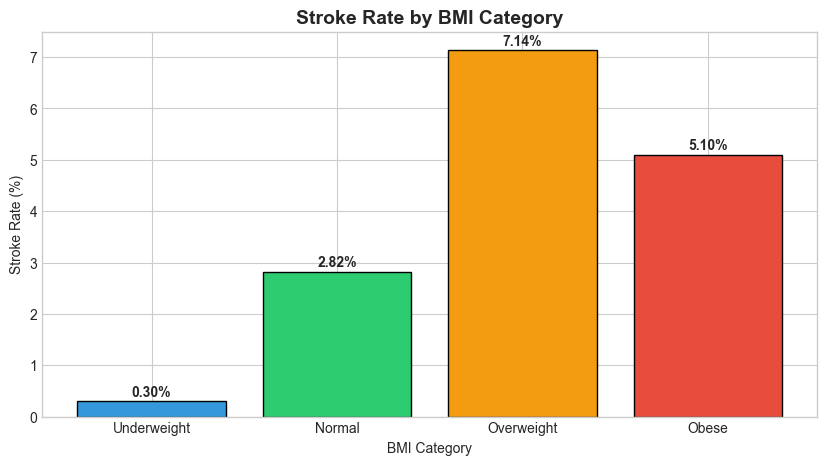

In [29]:
# 7. BMI Analysis
fig, ax = plt.subplots(figsize=(10, 5))
bmi_data = get_stroke_rate(df_clean, 'bmi_category')
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
bmi_data['bmi_category'] = pd.Categorical(bmi_data['bmi_category'], categories=bmi_order, ordered=True)
bmi_data = bmi_data.sort_values('bmi_category')
colors = [COLORS['primary'], COLORS['no_stroke'], COLORS['warning'], COLORS['stroke']]
bars = ax.bar(bmi_data['bmi_category'].astype(str), bmi_data['stroke_rate'], 
              color=colors, edgecolor='black')
for bar, rate in zip(bars, bmi_data['stroke_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
ax.set_title('Stroke Rate by BMI Category', fontsize=14, fontweight='bold')
ax.set_xlabel('BMI Category')
ax.set_ylabel('Stroke Rate (%)')
save_fig(fig, '07_bmi_analysis.png')
plt.show()

Saved: ../visualizations/08_glucose_analysis.png


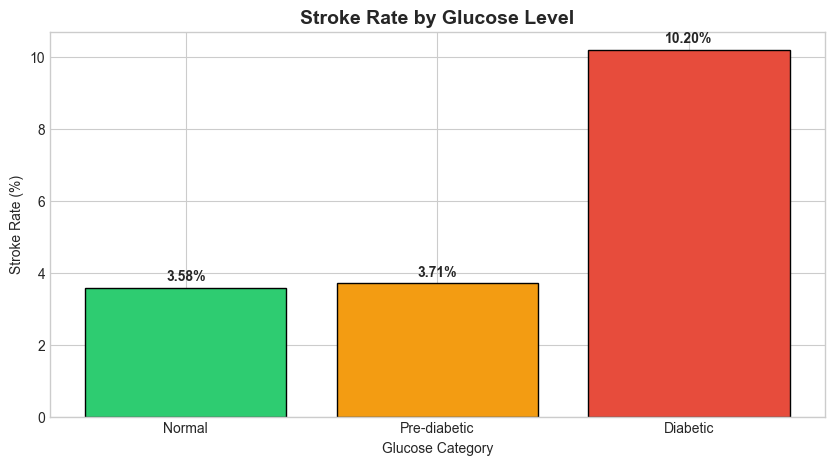

In [30]:
# 8. Glucose Analysis
fig, ax = plt.subplots(figsize=(10, 5))
glucose_data = get_stroke_rate(df_clean, 'glucose_category')
glucose_order = ['Normal', 'Pre-diabetic', 'Diabetic']
glucose_data['glucose_category'] = pd.Categorical(glucose_data['glucose_category'], 
                                                   categories=glucose_order, ordered=True)
glucose_data = glucose_data.sort_values('glucose_category')
colors = [COLORS['no_stroke'], COLORS['warning'], COLORS['stroke']]
bars = ax.bar(glucose_data['glucose_category'].astype(str), glucose_data['stroke_rate'], 
              color=colors, edgecolor='black')
for bar, rate in zip(bars, glucose_data['stroke_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
ax.set_title('Stroke Rate by Glucose Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Glucose Category')
ax.set_ylabel('Stroke Rate (%)')
save_fig(fig, '08_glucose_analysis.png')
plt.show()

Saved: ../visualizations/09_work_type_analysis.png


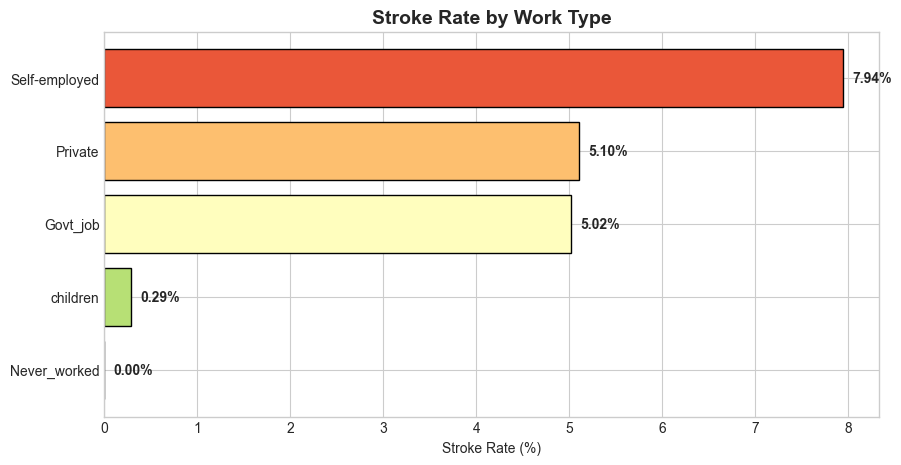

In [31]:
# 9. Work Type Analysis
fig, ax = plt.subplots(figsize=(10, 5))
work_data = get_stroke_rate(df_clean, 'work_type').sort_values('stroke_rate', ascending=True)
colors = sns.color_palette('RdYlGn_r', len(work_data))
bars = ax.barh(work_data['work_type'], work_data['stroke_rate'], color=colors, edgecolor='black')
for bar, rate in zip(bars, work_data['stroke_rate']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{rate:.2f}%', ha='left', va='center', fontsize=10, fontweight='bold')
ax.set_title('Stroke Rate by Work Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Stroke Rate (%)')
save_fig(fig, '09_work_type_analysis.png')
plt.show()

Saved: ../visualizations/10_residence_analysis.png


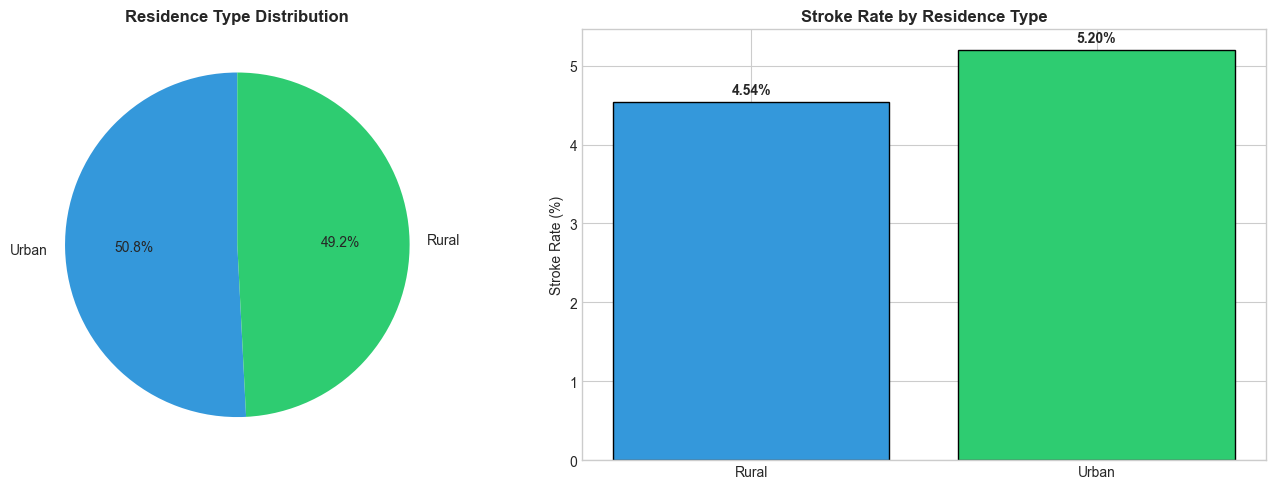

In [32]:
# 10. Residence Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residence distribution
residence_counts = df_clean['Residence_type'].value_counts()
axes[0].pie(residence_counts, labels=residence_counts.index, autopct='%1.1f%%',
            colors=[COLORS['primary'], COLORS['no_stroke']], startangle=90)
axes[0].set_title('Residence Type Distribution', fontsize=12, fontweight='bold')

# Stroke rate by residence
residence_data = get_stroke_rate(df_clean, 'Residence_type')
bars = axes[1].bar(residence_data['Residence_type'], residence_data['stroke_rate'],
                   color=[COLORS['primary'], COLORS['no_stroke']], edgecolor='black')
for bar, rate in zip(bars, residence_data['stroke_rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{rate:.2f}%', ha='center', fontsize=10, fontweight='bold')
axes[1].set_title('Stroke Rate by Residence Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Stroke Rate (%)')

plt.tight_layout()
save_fig(fig, '10_residence_analysis.png')
plt.show()

Saved: ../visualizations/11_correlation_heatmap.png


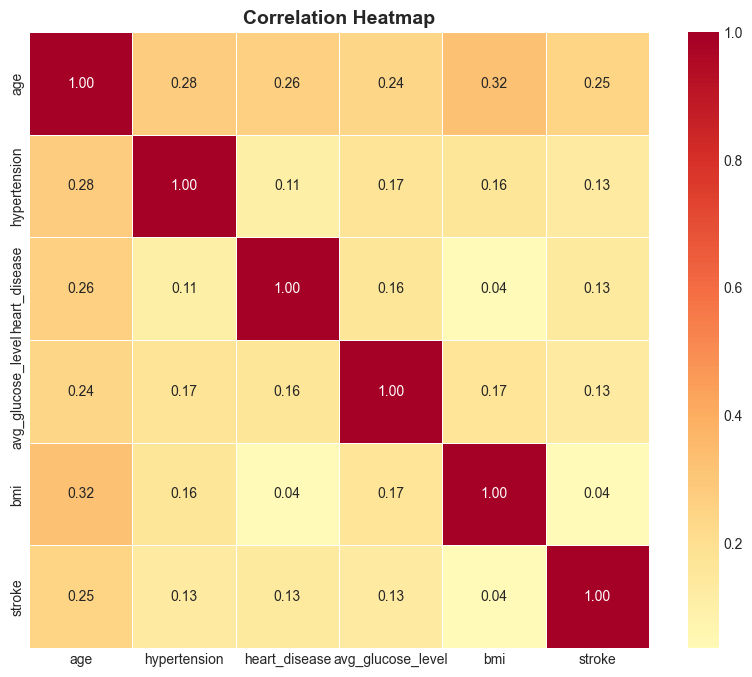

In [33]:
# 11. Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
numeric_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', linewidths=0.5, ax=ax)
ax.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
save_fig(fig, '11_correlation_heatmap.png')
plt.show()

## 8. Export Data for Tableau

In [34]:
# Export main data
df_clean.to_csv(TABLEAU_DIR / 'stroke_data_tableau.csv', index=False)
print('Exported: stroke_data_tableau.csv')

# Export summary tables
get_stroke_rate(df_clean, 'age_group').to_csv(TABLEAU_DIR / 'age_group_tableau.csv', index=False)
get_stroke_rate(df_clean, 'gender').to_csv(TABLEAU_DIR / 'gender_tableau.csv', index=False)
get_stroke_rate(df_clean, 'hypertension').to_csv(TABLEAU_DIR / 'hypertension_tableau.csv', index=False)
get_stroke_rate(df_clean, 'heart_disease').to_csv(TABLEAU_DIR / 'heart_disease_tableau.csv', index=False)
get_stroke_rate(df_clean, 'smoking_status').to_csv(TABLEAU_DIR / 'smoking_tableau.csv', index=False)
get_stroke_rate(df_clean, 'work_type').to_csv(TABLEAU_DIR / 'work_type_tableau.csv', index=False)
get_stroke_rate(df_clean, 'Residence_type').to_csv(TABLEAU_DIR / 'residence_tableau.csv', index=False)
get_stroke_rate(df_clean, 'bmi_category').to_csv(TABLEAU_DIR / 'bmi_category_tableau.csv', index=False)
get_stroke_rate(df_clean, 'glucose_category').to_csv(TABLEAU_DIR / 'glucose_category_tableau.csv', index=False)

# Create risk factors summary for comparison chart
hyper = get_stroke_rate(df_clean, 'hypertension')
heart = get_stroke_rate(df_clean, 'heart_disease')
smoking = get_stroke_rate(df_clean, 'smoking_status')
bmi = get_stroke_rate(df_clean, 'bmi_category')
glucose = get_stroke_rate(df_clean, 'glucose_category')

risk_summary = pd.DataFrame({
    'Risk_Factor': ['Hypertension', 'Hypertension', 'Heart Disease', 'Heart Disease',
                    'Smoking', 'Smoking', 'BMI', 'BMI', 'Glucose', 'Glucose'],
    'Status': ['Yes', 'No', 'Yes', 'No', 
               'Formerly Smoked', 'Never Smoked', 'Obese', 'Normal', 'Diabetic', 'Normal'],
    'Stroke_Rate': [
        hyper[hyper['hypertension']==1]['stroke_rate'].values[0],
        hyper[hyper['hypertension']==0]['stroke_rate'].values[0],
        heart[heart['heart_disease']==1]['stroke_rate'].values[0],
        heart[heart['heart_disease']==0]['stroke_rate'].values[0],
        smoking[smoking['smoking_status']=='formerly smoked']['stroke_rate'].values[0],
        smoking[smoking['smoking_status']=='never smoked']['stroke_rate'].values[0],
        bmi[bmi['bmi_category']=='Obese']['stroke_rate'].values[0],
        bmi[bmi['bmi_category']=='Normal']['stroke_rate'].values[0],
        glucose[glucose['glucose_category']=='Diabetic']['stroke_rate'].values[0],
        glucose[glucose['glucose_category']=='Normal']['stroke_rate'].values[0]
    ]
})
risk_summary.to_csv(TABLEAU_DIR / 'risk_factors_summary.csv', index=False)
print('Exported: risk_factors_summary.csv')

print(f'\nAll files exported to: {TABLEAU_DIR}')

Exported: stroke_data_tableau.csv
Exported: risk_factors_summary.csv

All files exported to: ../tableau


## 9. Key Findings

### Age is the Strongest Predictor
- Stroke risk increases significantly with age
- Patients aged 61-75 have the highest stroke rate
- Average age of stroke patients is much higher than non-stroke patients

### Medical Conditions Matter
- Hypertension patients have ~2.5x higher stroke rate
- Heart disease patients have ~2.8x higher stroke rate
- These conditions are strong indicators of stroke risk

### Lifestyle Factors
- Former smokers show the highest stroke rate among smoking categories
- Higher BMI (Obese category) correlates with increased stroke risk
- Diabetic glucose levels associated with higher stroke rate

### Work Type Patterns
- Self-employed individuals show higher stroke rates
- Children have the lowest stroke rate (as expected)
- Private sector workers have moderate stroke rates

### Residence and Gender
- Urban and Rural residents show similar stroke rates
- Males have slightly higher stroke rates than females

## 10. Recommendations

Based on the analysis:

1. **Focus on Elderly Population** - Regular health screenings for people above 60

2. **Monitor Medical Conditions** - Close monitoring of hypertension and heart disease patients

3. **Lifestyle Interventions** - Programs for smoking cessation and weight management

4. **Blood Sugar Control** - Regular glucose monitoring for diabetic and pre-diabetic patients

5. **Awareness Campaigns** - Target high-risk groups with stroke prevention education

## 11. Summary

This analysis identified key risk factors for stroke:
- **Age** is the most significant predictor
- **Medical history** (hypertension, heart disease) greatly increases risk
- **Lifestyle factors** (smoking, BMI, glucose) contribute to stroke occurrence

The findings support targeted interventions for high-risk groups and emphasize the importance of preventive healthcare measures.

---

*Analysis completed by Ishak Islam | UMID28072552431 | Unified Mentor Internship*